In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from coxdev import CoxDeviance
import rpy2
%load_ext rpy2.ipython
rng = np.random.default_rng(0)
from itertools import product, combinations

In [2]:
def plot_data(start, event, ax=None, by='event'):
    start = np.asarray(start)
    event = np.asarray(event)
    if by == 'event':
        order = np.argsort(event)
    else:
        order = np.argsort(start)
    event = event[order]
    start = start[order]
    n = event.shape[0]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.scatter(start, np.arange(n), marker='o', facecolors='none', edgecolors='k', s=100)
        ax.scatter(event, np.arange(n), marker='o', facecolors='red', edgecolors='k', s=100)
        for i, (s, e) in enumerate(zip(start, event)):
            ax.plot([s,e], [i,i], 'k')

# What can happen at a point

At any time $t \in \mathbb{R}$, one of the following happens:

- (0,0): $\# \{i:s_i=t\}=0, \# \{i:t_i=t\}=0$ (these are irrelevant)
- (0,1): $\# \{i:s_i=t\}=0, \# \{i:t_i=t\}=1$
- (0,>1):$\# \{i:s_i=t\}=0, \# \{i:t_i=t\}>1$
- (1,0): $\# \{i:s_i=t\}=1, \# \{i:t_i=t\}=0$
- (1,1): $\# \{i:s_i=t\}=1, \# \{i:t_i=t\}=1$
- (1,>1): $\# \{i:s_i=t\}=0, \# \{i:t_i=t\}>1$
- (>1,0): $\# \{i:s_i=t\}>1, \# \{i:t_i=t\}=0$
- (>1,1):$\# \{i:s_i=t\}>1, \# \{i:t_i=t\}=1$
- (>1,>1):$\# \{i:s_i=t\}>1, \# \{i:t_i=t\}>1$

Letting $>1=2$ we write a function to simulate from these possibilities

In [3]:
def sample(size=1):
    return rng.uniform(size=size) + 0.5

def simulate(start_count, event_count, size=1):
    size = rng.poisson(size) + 1
    if start_count == 0 and event_count == 0:
        return None
    elif ((start_count == 0 and event_count == 1) or   # both of this well ensure there are unique starts or 
                                                      # stops
          (start_count == 1 and event_count == 0)):
        start = sample(size=size)
        event = start + sample(size=size)
        
    elif (start_count == 0) and (event_count == 2): # ties in event but not starts
        event = sample() * np.ones(size)
        start = event - sample(size=size)
        min_start = start.min()
        E = sample()
        event += min_start + E
        start += min_start + E
    elif (start_count == 2) and (event_count == 0): # ties in starts but not events
        start = sample() * np.ones(size)
        event = start + sample(size=size)
    elif (start_count == 1) and (event_count == 1): # ties in starts but not events
        start = []
        event = []
        for _ in range(size):
            U = sample()
            start.extend([U-sample(), U])
            event.extend([U, U+sample()])
        start = np.asarray(start).reshape(-1)
        event = np.asarray(event).reshape(-1)
        
    elif (start_count == 2) and (event_count == 1): # ties in starts but not events
        start = sample() * np.ones(size)
        event = start + sample(size=size)
        E = sample()
        event = np.hstack([event, start[0]])
        start = np.hstack([start, start[0] - sample()])

    elif (start_count == 1) and (event_count == 2): # multiple ties in events but not starts
        event = sample() * np.ones(size)
        start = event - sample(size=size)
        E = sample()
        start = np.hstack([start, event[0]])
        event = np.hstack([event, event[0] + sample()])

    elif (start_count == 2) and (event_count == 2): # ties in starts but not events
        U = sample()
        event = U * np.ones(size)
        start = event - sample(size=size)
        size2 = rng.poisson(size) + 1
        start2 = U * np.ones(size2)
        event2 = start2 + sample(size=size2)
        start = np.hstack([start, start2])
        event = np.hstack([event, event2])

    size = start.shape[0]
    status = rng.choice([0,1], size=size)
    return pd.DataFrame({'start':start, 'event':event, 'status':status})

# All 8 different tie behavior (some are actually the same...)

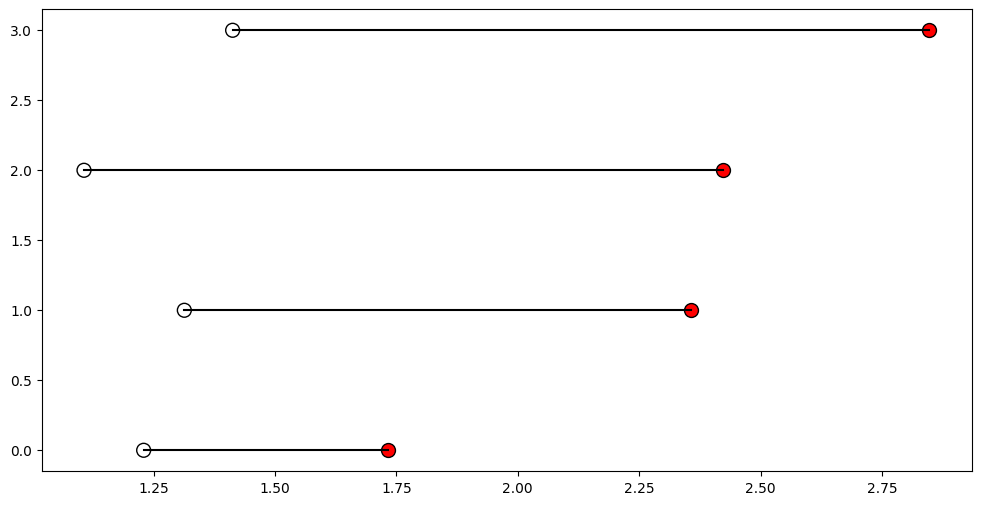

In [4]:
data = simulate(0, 1, 5)
plot_data(data['start'], data['event'])

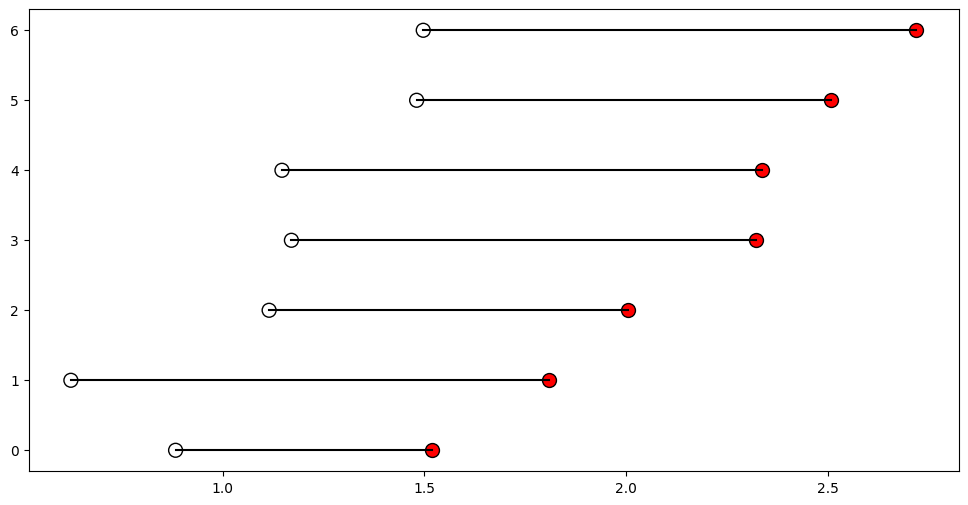

In [5]:
data = simulate(1, 0, 5)
plot_data(data['start'], data['event'])

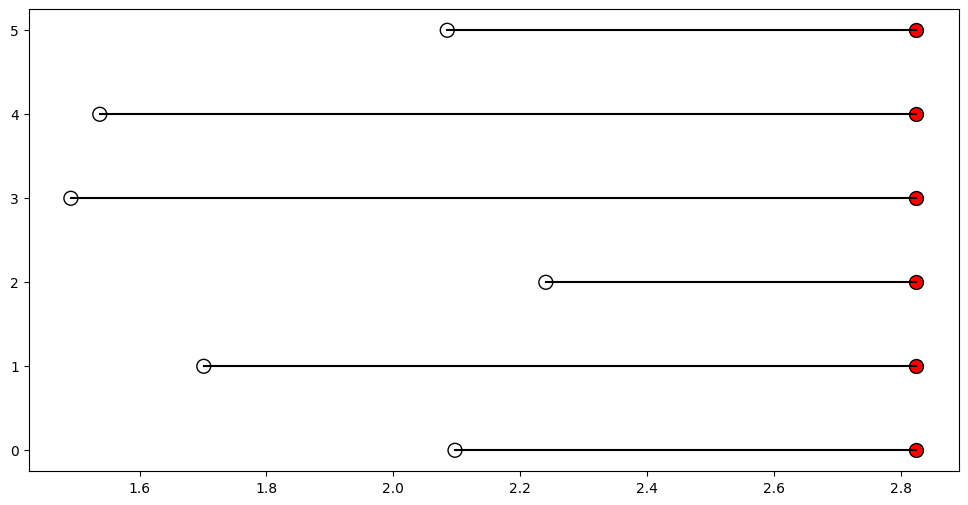

In [6]:
data = simulate(0, 2, 5)
plot_data(data['start'], data['event'])

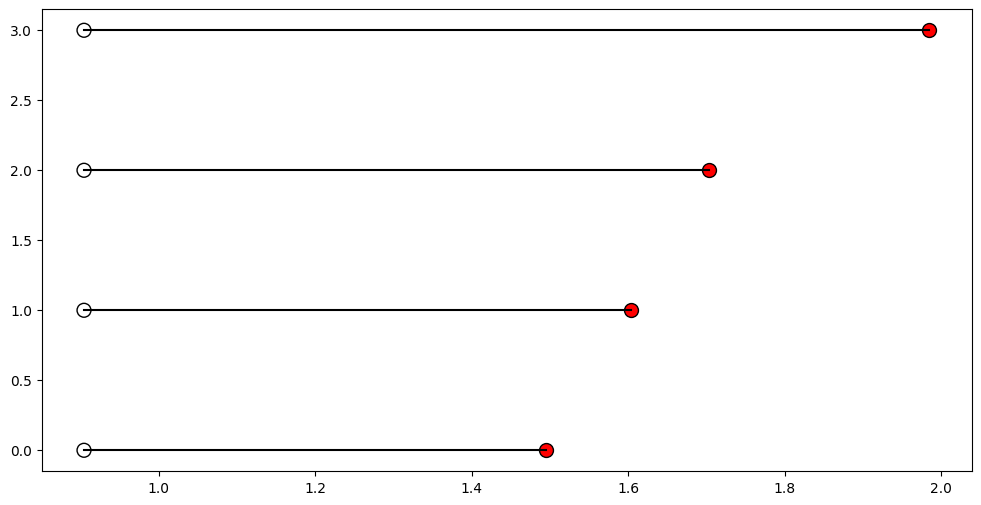

In [7]:
data = simulate(2, 0, 5)
plot_data(data['start'], data['event'])

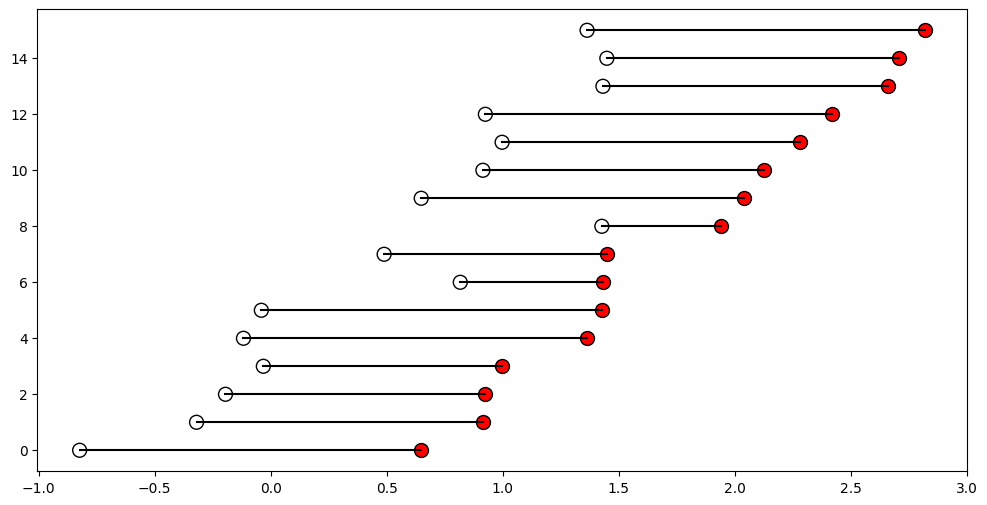

In [8]:
data = simulate(1, 1, 5) # single ties of (start, stop)
plot_data(data['start'], data['event'])

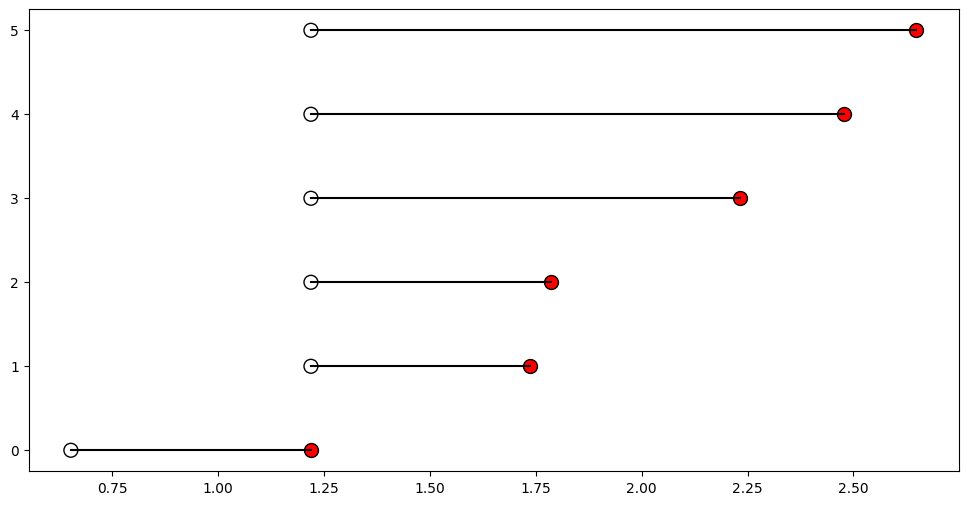

In [9]:
data = simulate(2, 1, 5)
plot_data(data['start'], data['event'])

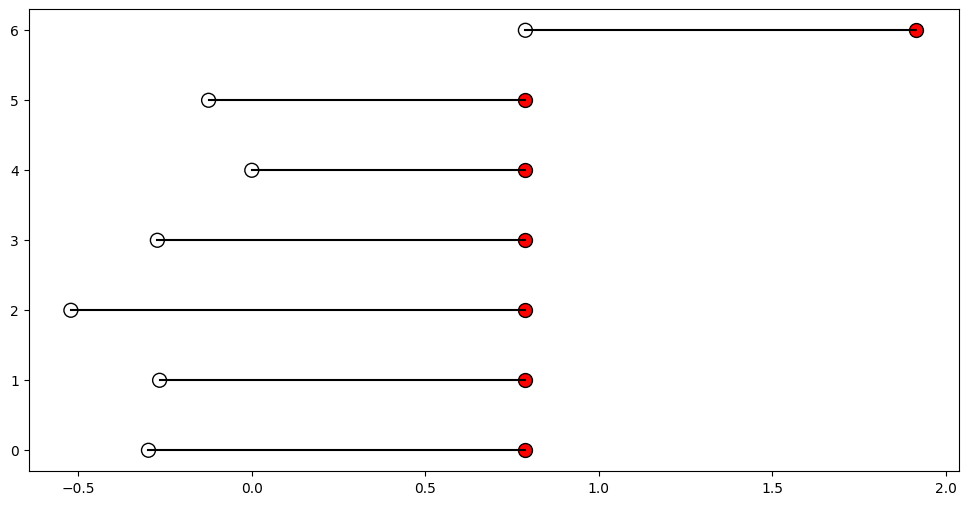

In [10]:
data = simulate(1, 2, 5)
plot_data(data['start'], data['event'])

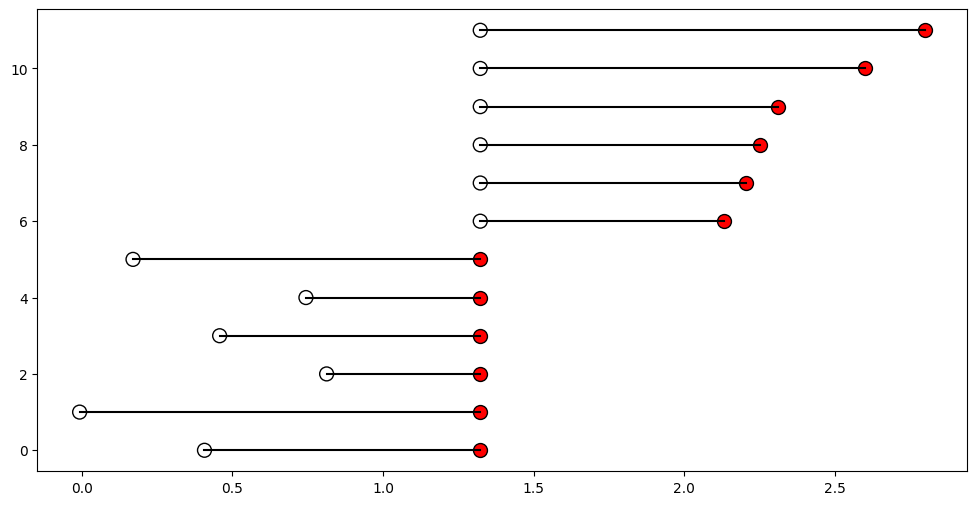

In [11]:
data = simulate(2, 2, 5)
plot_data(data['start'], data['event'])

In [12]:
def evaluate_event_map(event, status, start):
    coxdev = CoxDeviance(event=event, status=status, start=start)
    n = coxdev._start.shape[0]
    start = np.asarray(start)
    event = np.asarray(event)
    status = np.asarray(status)
    testA1 = np.empty((n,n))
    testA2 = np.empty((n,n))
    testA3 = np.empty((n,n))
    testB1 = np.empty((n,n))
    testB2 = np.empty((n,n))
    testB3 = np.empty((n,n))

    for i, c in product(np.arange(n), np.arange(n)):
        B_i = coxdev._event_order[i]
        B_c = coxdev._start_order[c]
        A_i = i
        A_c = c
        testA1[i, c] = (coxdev._start_map[A_c] > coxdev._last[A_i])
        testB1[i, c] = (start[B_c] > event[B_i]) * (event[B_c] >= event[B_i])
        testB2[i,c] = (start[B_c] > event[B_i]) 
        testB3[i,c] = (A_i >= coxdev._event_map[B_c])
        testA2[i, c] = i < coxdev._first_start[A_c]  * (coxdev._event[A_c] >= coxdev._event[A_i])
        testA3[i, c] = i < coxdev._start_map[A_c]  * (coxdev._event[A_c] >= coxdev._event[A_i])

    
    return (np.fabs(testA1==testB1).mean(), 
            np.fabs(testA2==testA3).mean(), 
            np.fabs(testA1==testA3).mean(),
            np.fabs(testB1==testB2).mean(),
            np.fabs(testB1==testB3).mean())

In [13]:
%%R
library(survival)
library(glmnet)

Loading required package: Matrix
Loaded glmnet 4.1-8


In [14]:
def get_R_result(event, status, start, eta, weight, time=False):

    %R -i event,status,start,eta,weight 
    %R eta = as.numeric(eta)
    %R weight = as.numeric(weight)

    if start is not None:
        %R Y = Surv(start, event, status)
        if time: 
            %R print(system.time(for (i in 1:400) {c(rnorm(length(eta)), glmnet:::coxnet.deviance3(pred=eta, y=Y, weight=weight, std.weights=FALSE), glmnet:::coxgrad3(eta, Y, weight, std.weights=FALSE, diag.hessian=TRUE))}))
        %R D_R = glmnet:::coxnet.deviance3(pred=eta, y=Y, weight=weight, std.weights=FALSE)
        %R G_R = glmnet:::coxgrad3(eta, Y, weight, std.weights=FALSE, diag.hessian=TRUE)
    else:
        %R Y = Surv(event, status)
        if time:
            %R print(system.time(for (i in 1:400) {c(rnorm(length(eta)), glmnet:::coxnet.deviance2(pred=eta, y=Y, weight=weight, std.weights=FALSE), glmnet:::coxgrad2(eta, Y, weight, std.weights=FALSE, diag.hessian=TRUE))}))
        %R D_R = glmnet:::coxnet.deviance2(pred=eta, y=Y, weight=weight, std.weights=FALSE)
        %R G_R = glmnet:::coxgrad2(eta, Y, weight, std.weights=FALSE, diag.hessian=TRUE)
    
    %R H_R = attr(G_R, 'diag_hessian')
    %R G_R = -2 * G_R
    %R H_R = -2 * H_R
    %R -o D_R,H_R,G_R
    return D_R, G_R, H_R

In [15]:
dataset_types = [(0,1), (1,0), (1, 1), (0, 2), (2, 0), (2, 1), (1, 2), (2, 2)]
size, nrep, tol = 4, 1, 1e-10
datasets = {}
for t in dataset_types:
    datasets[t] = pd.concat([simulate(t[0], t[1], size=size) for _ in range(nrep)])
for i in range(1, 9):
    for v in combinations(dataset_types, i):
        data = pd.concat([datasets[a] for a in v])
        coxdev = CoxDeviance(event=data['event'],
                             start=data['start'],
                             status=data['status'],
                             tie_breaking='breslow')
        eta = rng.standard_normal(data.shape[0])
        weight = rng.uniform(size=data.shape[0]) + 0.2
        D_R, G_R, H_R = get_R_result(data['event'],
                                     data['status'],
                                     data['start'],
                                     eta,
                                     weight)

       # print(evaluate_event_map(event=data['event'],
       #                          status=data['status'],
       #                          start=data['start']))
        C = coxdev(eta, weight)
        delta_D = np.fabs(D_R - C.deviance) / np.fabs(D_R)
        delta_G = np.linalg.norm(G_R - C.gradient) / np.linalg.norm(G_R)
        delta_H = np.linalg.norm(H_R - C.diag_hessian) / np.linalg.norm(H_R)
        if delta_D > tol:
            print(v, delta_D, 'deviance')
        if delta_G > tol:
            print(v, delta_G, 'gradient')
        if delta_H > tol:
            print(v, delta_H, 'hessian')
        if np.fabs(D_R) == 0:
            print(v, 'coxdev3')

        # check without start times
        
        coxdev = CoxDeviance(event=data['event'],
                             start=None,
                             status=data['status'],
                             tie_breaking='breslow')
        eta = rng.standard_normal(data.shape[0])
        weight = np.ones(data.shape[0])
        D_R, G_R, H_R = get_R_result(data['event'],
                                     data['status'],
                                     None,
                                     eta,
                                     weight)
        C2 = coxdev(eta, weight)
        delta_D = np.fabs(D_R - C2.deviance) / np.fabs(C2.deviance)
        delta_G = np.linalg.norm(G_R - C2.gradient) / np.linalg.norm(C2.gradient)
        delta_H = np.linalg.norm(H_R - C2.diag_hessian) / np.linalg.norm(C2.diag_hessian)
        if delta_D > tol:
            print(v, delta_D, 'deviance')
        if delta_G > tol:
            print(v, delta_G, 'gradient')
        if delta_H > tol:
            print(v, delta_H, 'hessian')
        if np.fabs(D_R) == 0:
            print(v, 'coxdev2')


## All 8 different "types" of points in one dataset

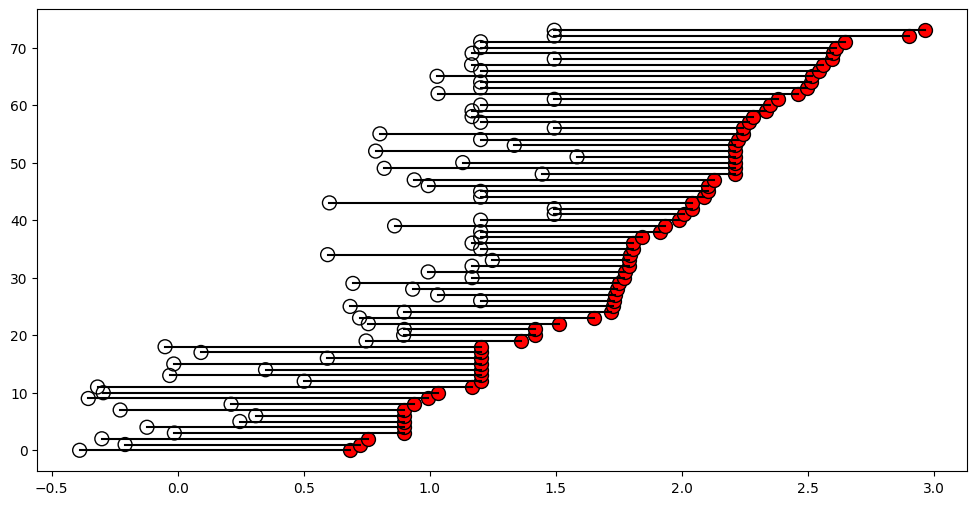

In [16]:
data = pd.concat([simulate(t[0], t[1], size=4) for t in dataset_types])
plot_data(data['start'], data['event'], by='event')

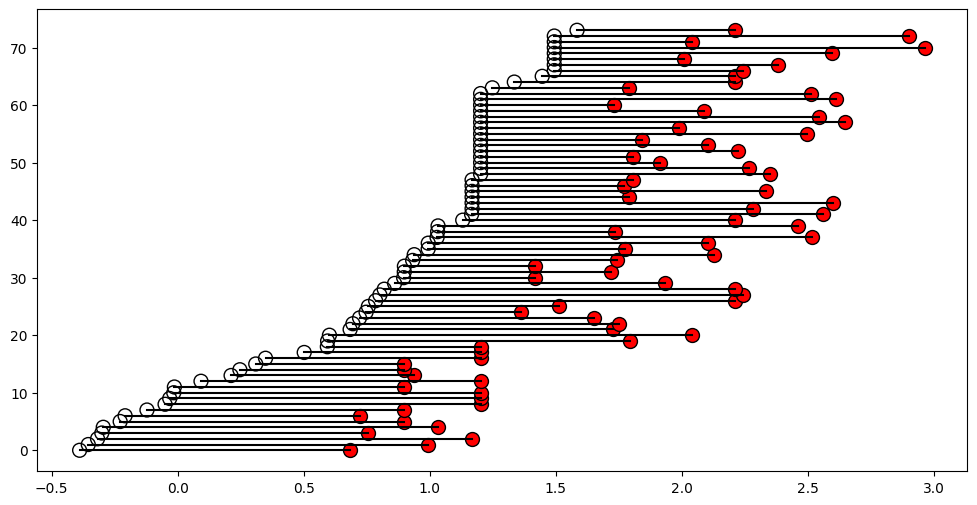

In [17]:
plot_data(data['start'], data['event'], by='start')

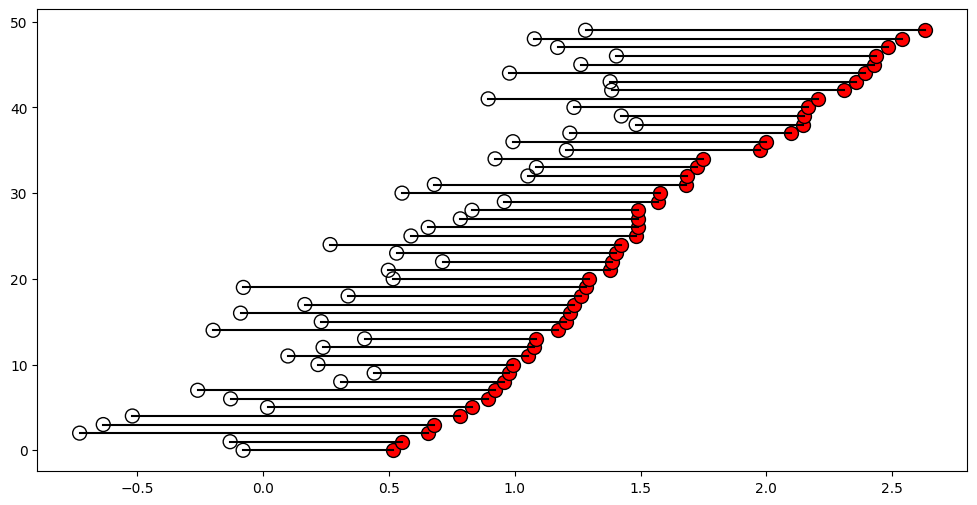

In [18]:
data = simulate(1, 1, 20)
plot_data(data['start'], data['event'])
coxdev = CoxDeviance(event=data['event'],
                     start=data['start'],
                     status=data['status'])


In [19]:
coxdev._last

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [20]:
S = coxdev._start_map
S_cp = S.copy()
S_cp[coxdev._event_order] = S
S_cp[coxdev._start_order][10],

(0,)

In [21]:
coxdev._first

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [22]:
coxdev._last

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])